<h1 align="center"><a href="https://github.com/sborquez/gerumo/">*</a> GeRUMo - Gamma-ray Events Reconstructor with Uncertain models</h1>

<h2 align="center">Evaluate</h2>

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/2f/Cta_concept.jpg" width="30%" alt="icon"></img>
</center>



## Setup

The first step is to sync this notebook with Google Drive, and change directory to gerumo repository.

In [1]:
!pip install ctaplot

     |████████████████████████████████| 4.3MB 13.5MB/s 
     |████████████████████████████████| 6.4MB 48.8MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
  Created wheel for ctaplot: filename=ctaplot-0.5.3-cp36-none-any.whl size=4338455 sha256=a04c14003dc67f737e2905ab4e68b35fd11fd0e9eac2ef81c244f883aab397dd
  Stored in directory: /root/.cache/pip/wheels/47/7c/aa/c930430d25783f863b9a32ee6a5920d061ba6ac94fad4268e0
Successfully built ctaplot


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd "/content/drive/My Drive/Projects/gerumo"
!ls

/content/drive/My Drive/Projects/gerumo
docs		gerumo	 notebooks  Pipfile.lock  setup.py  train
enviroment.yml	LICENSE  Pipfile    README.md	  tests


## Load Gerumo and extra modules.

In [5]:
from gerumo import *

import logging
import time
from os import path

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.metrics import r2_score
import json
from tqdm.notebook import tqdm
from IPython.core.display import display, HTML
import pprint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Angular Reconstruction

## Load Configuration file

In [6]:
config_file = "/content/drive/My Drive/Projects/gerumo/train/config/colab/alt_az/umonna_assembler_colab.json"

print(f"Loading config from: {config_file}")
with open(config_file) as cfg_file:
    config = json.load(cfg_file)

# Model
model_name = config["model_name"]
assembler_constructor = ASSEMBLERS[config["assembler_constructor"]]

# Dataset Parameters
output_folder = config["output_folder"]
replace_folder_test = config["replace_folder_test"]
test_events_csv    = config["test_events_csv"]
test_telescope_csv = config["test_telescope_csv"]

# Input and Target Parameters 
telescopes = config["telescopes"]
min_observations = config["min_observations"]
input_image_mode = config["input_image_mode"]
input_image_mask = config["input_image_mask"]
input_features = config["input_features"]
targets = config["targets"]
target_mode = "lineal"
target_shapes = config["target_shapes"]
target_domains = config["target_domains"]
target_resolutions = get_resolution(targets, target_domains, target_shapes)

# Prepare Generator target_mode_config 
target_mode_config = {
    "target_shapes":      tuple([target_shapes[target]      for target in targets]),
    "target_domains":     tuple([target_domains[target]     for target in targets]),
    "target_resolutions": tuple([target_resolutions[target] for target in targets])
}
if target_mode == "probability_map":
    target_sigmas = config["target_sigmas"]
    target_mode_config["target_sigmas"] = tuple([target_sigmas[target] for target in targets])

# Evaluation Parameters
evaluation_config = config["evaluation"]

Loading config from: /content/drive/My Drive/Projects/gerumo/train/config/colab/alt_az/umonna_assembler_colab.json


In [7]:
pprint.pprint(config, width=1)

{'assembler_constructor': 'umonna',
 'evaluation': {'Assembler': {'metrics_plot': True,
                              'predictions_points': True,
                              'predictions_raw': 'sample',
                              'probability_plot': 'sample',
                              'skip': False},
                'LST_LSTCam': {'metrics_plot': True,
                               'predictions_points': True,
                               'predictions_raw': 'sample',
                               'probability_plot': 'sample',
                               'skip': False},
                'MST_FlashCam': {'metrics_plot': True,
                                 'predictions_points': True,
                                 'predictions_raw': 'sample',
                                 'probability_plot': 'sample',
                                 'skip': False},
                'SST1M_DigiCam': {'metrics_plot': True,
                                  'predictions_points': True,
 

## Load Dataset

In [0]:
# Prepare datasets
test_dataset = load_dataset(test_events_csv, test_telescope_csv, replace_folder_test)
test_dataset = aggregate_dataset(test_dataset, az=True, log10_mc_energy=True)
test_dataset = filter_dataset(test_dataset, telescopes, min_observations, target_domains)

# Preprocessing pipes
preprocess_input_pipes = []
preprocess_output_pipes = []

## Data Generator

In [0]:
# Generators
batch_size = 64
telescope_types = [t for t in telescopes.keys() if telescopes[t] is not None]
test_generator = AssemblerGenerator(test_dataset, telescope_types,
                                    batch_size, 
                                    input_image_mode=input_image_mode, 
                                    input_image_mask=input_image_mask, 
                                    input_features=input_features,
                                    targets=targets,
                                    target_mode=target_mode, 
                                    target_mode_config=target_mode_config,
                                    preprocess_input_pipes=preprocess_input_pipes,
                                    preprocess_output_pipes=preprocess_output_pipes,
                                    include_event_id=True,
                                    include_true_energy=True
)

# Small test sample
sample_size = 1000
sample_events = np.random.choice(test_dataset.event_unique_id.unique(), sample_size)
sample_dataset = test_dataset[test_dataset.event_unique_id.isin(sample_events)]

sample_generator = AssemblerGenerator(sample_dataset, telescope_types,
                                    batch_size, 
                                    input_image_mode=input_image_mode, 
                                    input_image_mask=input_image_mask, 
                                    input_features=input_features,
                                    targets=targets,
                                    target_mode="lineal", 
                                    target_mode_config=target_mode_config,
                                    preprocess_input_pipes=preprocess_input_pipes,
                                    preprocess_output_pipes=preprocess_output_pipes,
                                    include_event_id=True,
                                    include_true_energy=True
)

display_events = [i for i,df in sample_dataset.groupby("event_unique_id") if len(df.type.unique()) == 3][:10]

### Generator sample

In [0]:
# Debug: Check if test dataset is loadable
#for i in tqdm(range(len(test_generator))):
#  _ = test_generator[i]

# Debug: Check if sample dataset is loadable
for i in tqdm(range(len(sample_generator))):
    _ = sample_generator[i]

## Load Models

In [10]:
sst = telescopes["SST1M_DigiCam"]
mst = telescopes["MST_FlashCam"]
lst = telescopes["LST_LSTCam"]
pprint.pprint(telescopes, width=1)

{'LST_LSTCam': '/content/drive/Shared '
               'drives/umonna/data/models/alt_az/small/UMONNA_UNIT_LST_V2_LST_LSTCam_crossentropy_e015_3.9625.h5',
 'MST_FlashCam': '/content/drive/Shared '
                 'drives/umonna/data/models/alt_az/small/UMONNA_UNIT_MST_V2_MST_FlashCam_crossentropy_e014_4.0626.h5',
 'SST1M_DigiCam': '/content/drive/Shared '
                  'drives/umonna/data/models/alt_az/small/UMONNA_UNIT_SST_V2_SST1M_DigiCam_crossentropy_e014_4.5449.h5'}


In [11]:
assembler = assembler_constructor(sst1m_model_or_path=sst,
                mst_model_or_path=mst,
                lst_model_or_path=lst,
                targets=targets, target_shapes=target_mode_config["target_shapes"],
                target_domains=target_mode_config["target_domains"],
                target_resolutions=target_mode_config["target_resolutions"],
                assembler_mode="normalized_product",
                point_estimation_mode="expected_value"
)
mode = assembler.mode

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Model Unit Predictions

In [0]:
target_domains_ = target_domains if isinstance(target_domains, dict) else target_domains_
targets = assembler.targets
models_results = {}

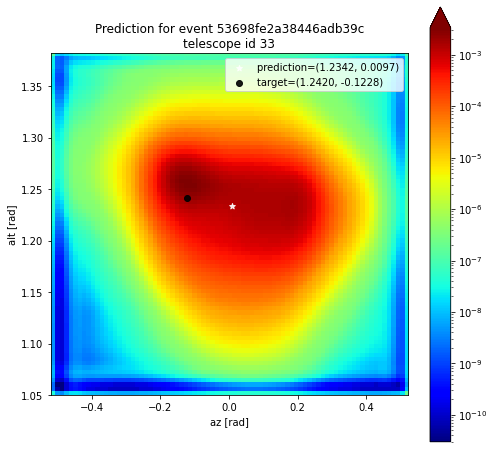

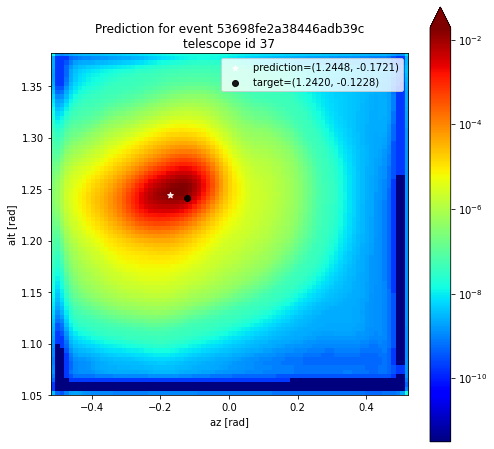

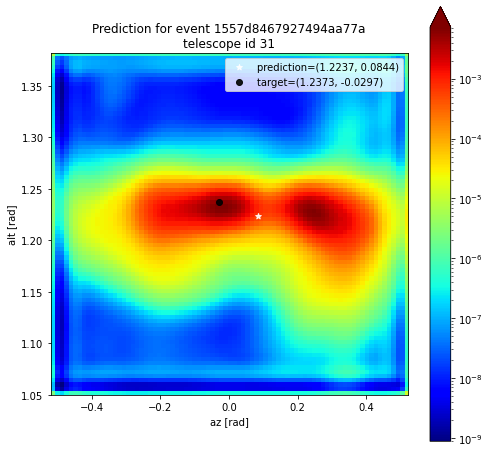

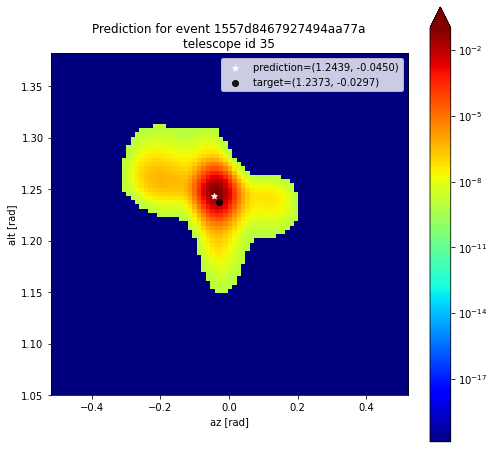

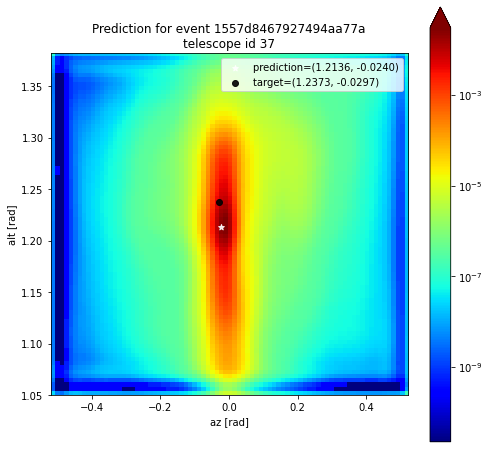

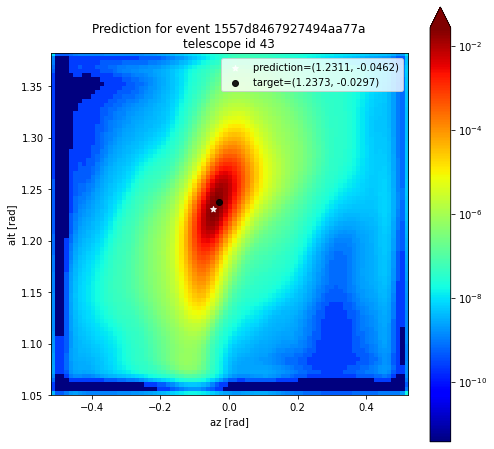

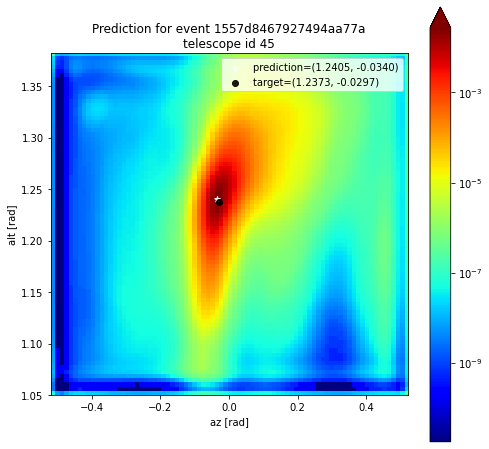

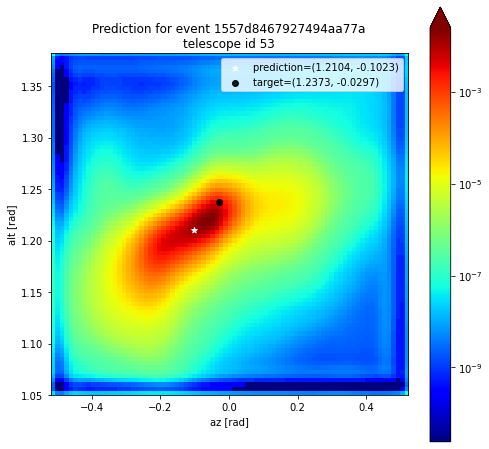

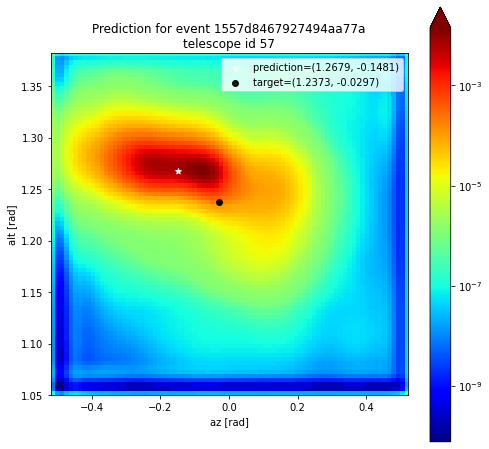

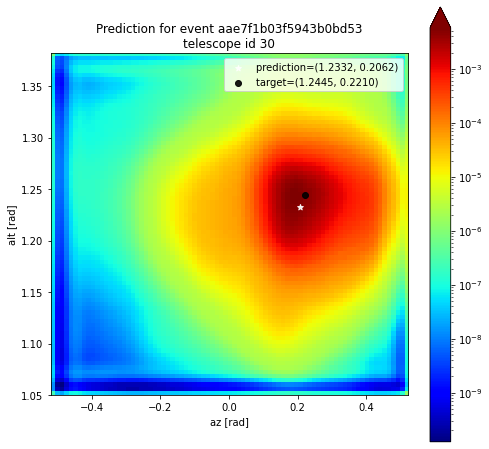

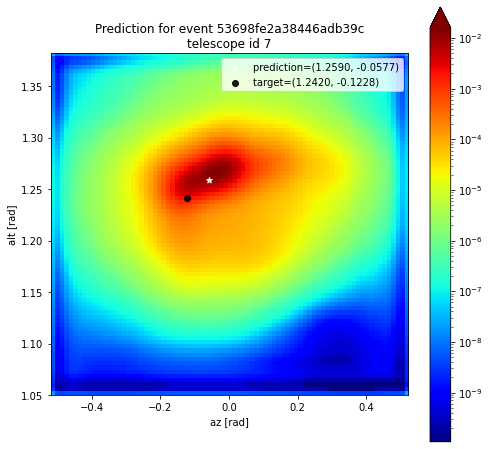

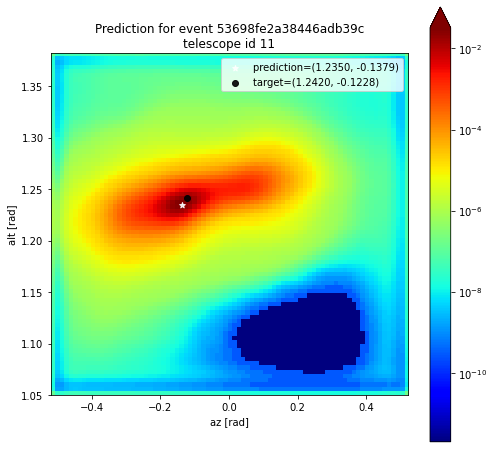

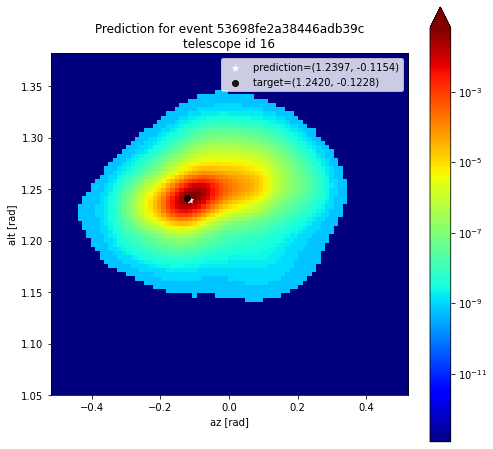

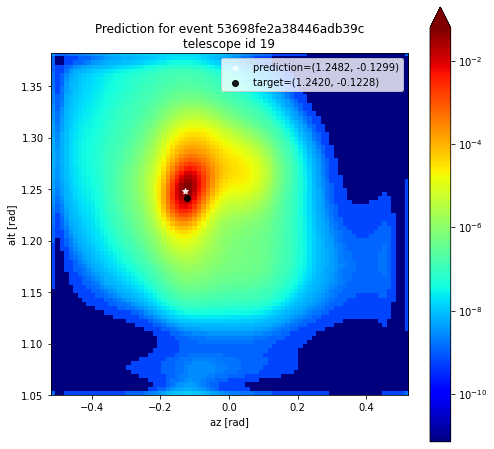

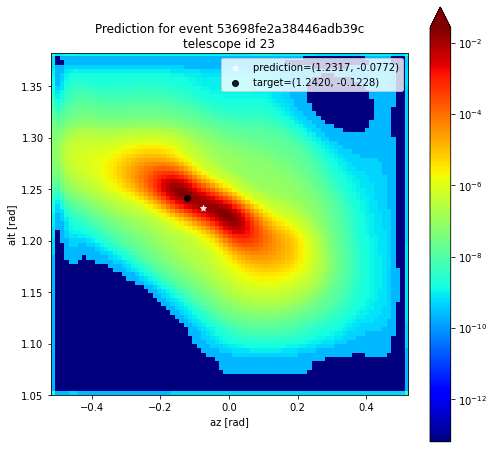

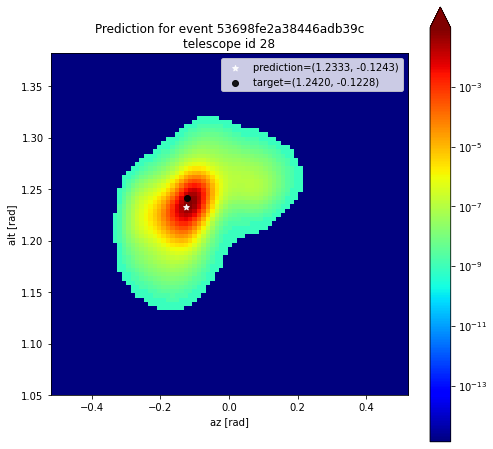

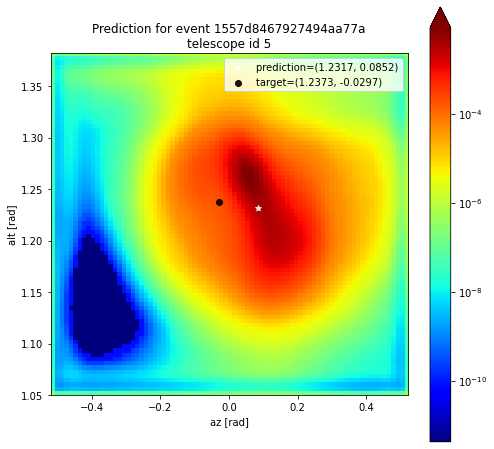

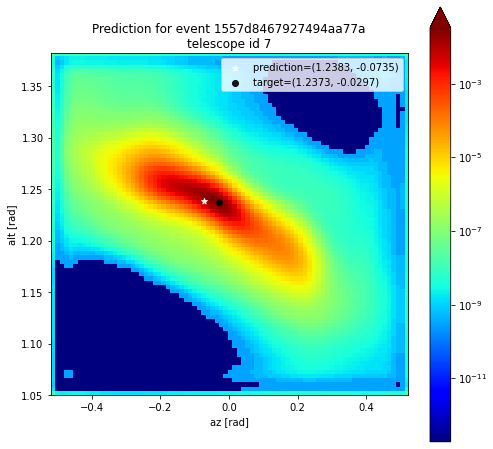

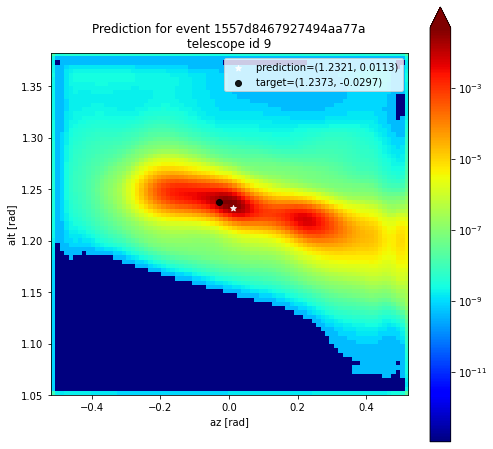

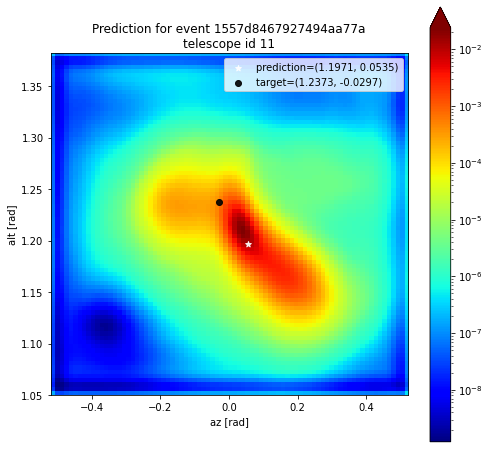

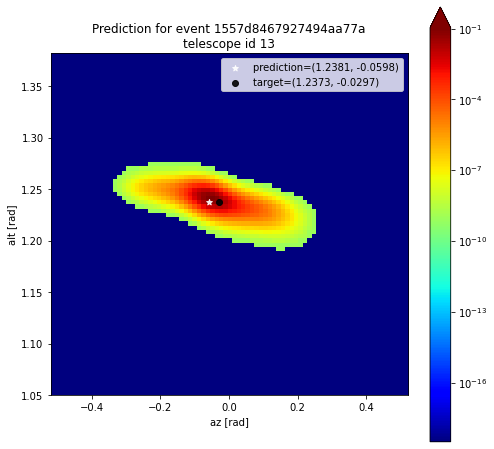

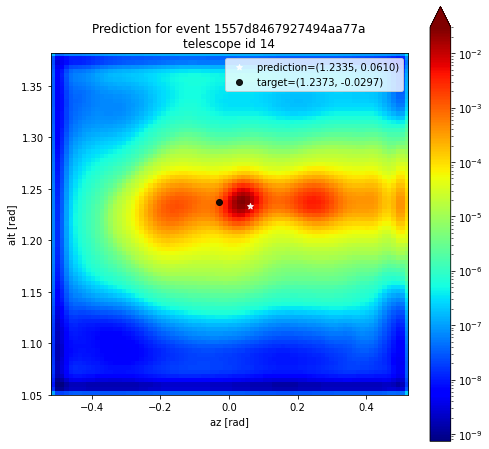

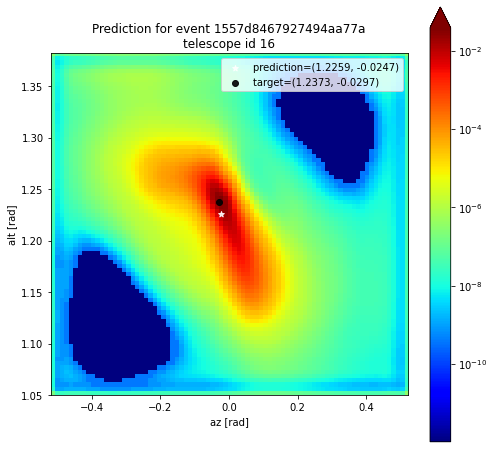

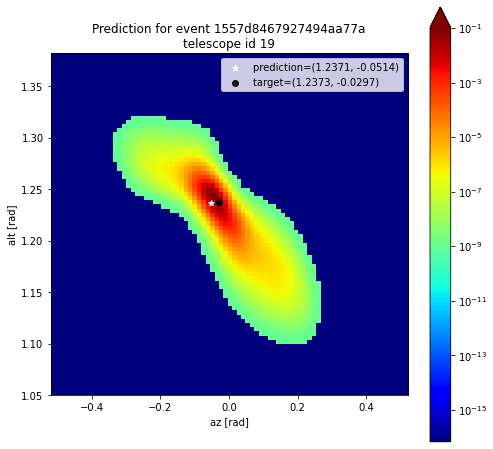

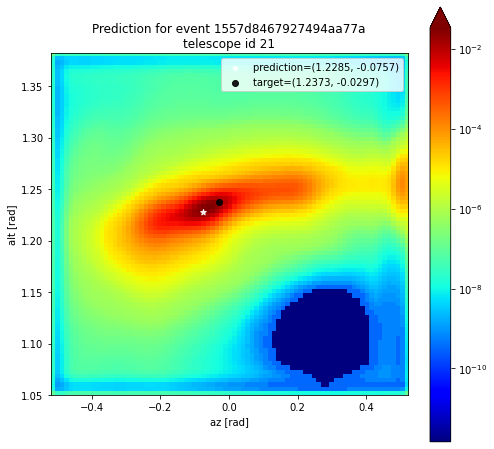

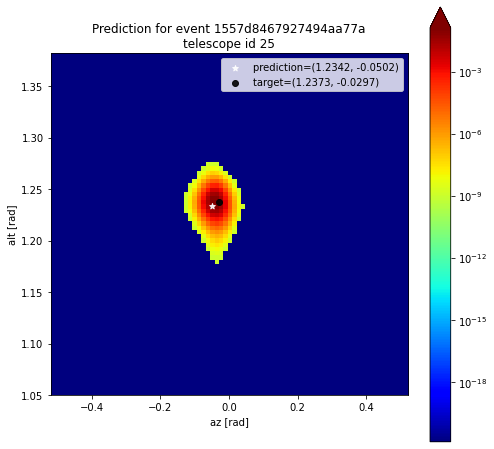

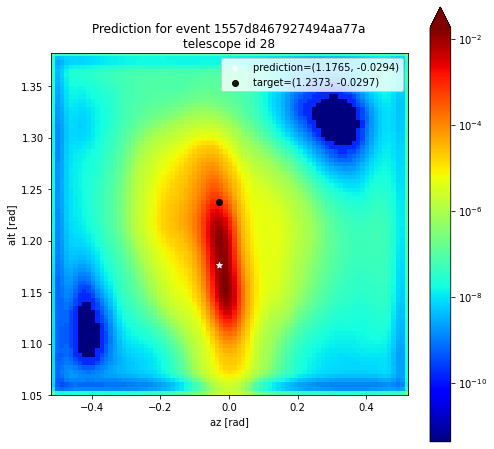

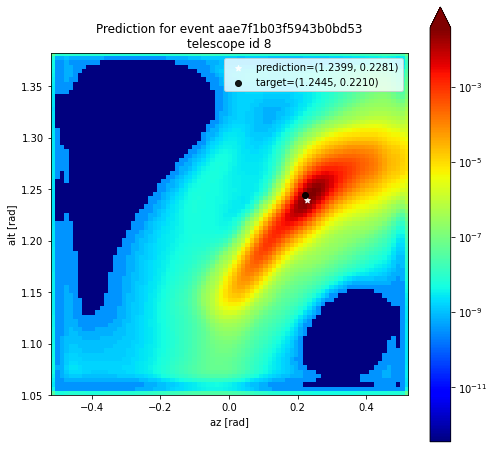

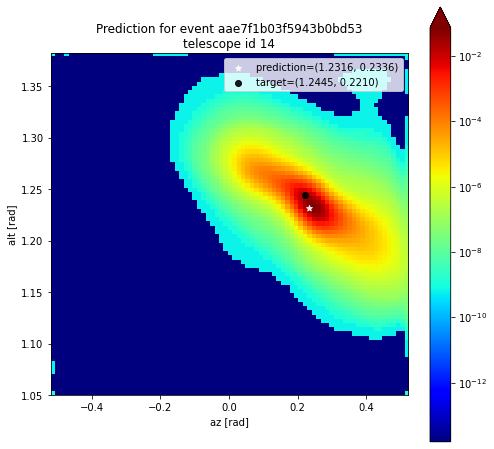

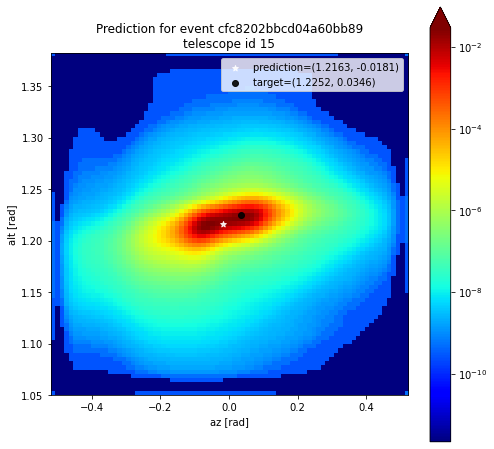

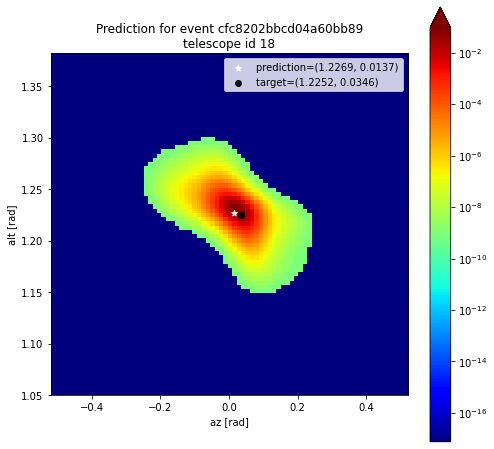

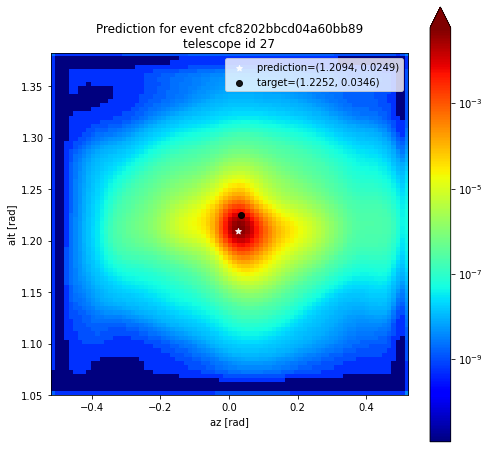

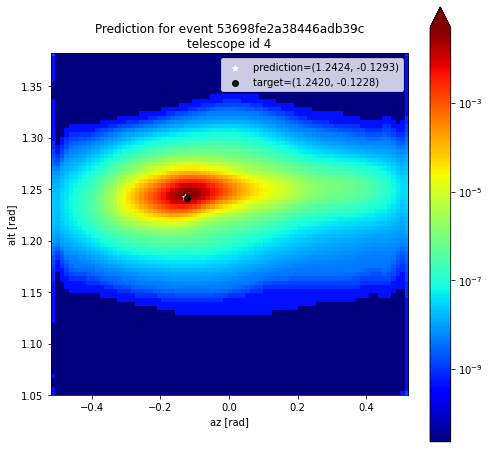

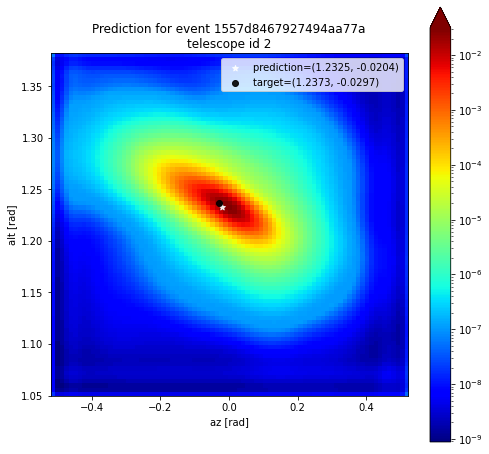

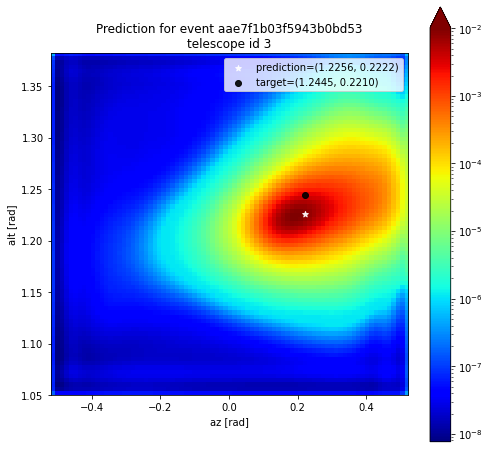

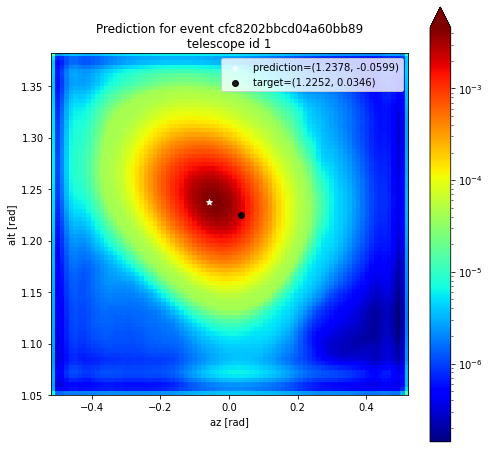

In [43]:
for telescope_i, model in assembler.models.items():
    display(HTML(f"<h3>{telescope_i}</h3>"))
    # Telescope Sample Dataset
    sample_dataset_telescope = filter_dataset(sample_dataset, [telescope_i], min_observations, target_domains)
    _batch_size =  1 if 0 < len(sample_dataset_telescope) < batch_size else batch_size
    telescope_generator = AssemblerUnitGenerator(sample_dataset_telescope, _batch_size, 
                                            input_image_mode=input_image_mode, 
                                            input_image_mask=input_image_mask, 
                                            input_features=input_features,
                                            targets=targets,
                                            target_mode="lineal",
                                            target_mode_config=target_mode_config,
                                            preprocess_input_pipes=preprocess_input_pipes,
                                            preprocess_output_pipes=preprocess_output_pipes,
                                            include_event_id=True,
                                            include_true_energy=True
                                            )
    # Prepare targets points
    targets_values = []
    event_ids = []
    telescopes_ids = []
    true_energy = []
    predictions = []
    predictions_points = []
    for x, t, meta in tqdm(telescope_generator):
        # Update records
        event_ids.extend(meta["event_id"])
        telescopes_ids.extend(meta["telescope_id"])
        true_energy.extend(meta["true_energy"])
        targets_values.extend(t)
        
        # Predictions
        p = model.predict(x)
        p_points = assembler.point_estimation(p)
        predictions_points.extend(p_points)

        # save some predictions
        for prediction, prediction_point, target, event_id, telescope_id in zip(p, p_points, t, meta["event_id"], meta["telescope_id"]):
            if event_id in display_events:
                #predictions.append((prediction)
                plot_assembler_prediction(prediction, prediction_point, targets, assembler.target_domains, assembler.target_resolutions, (event_id, telescope_id), target)
        
    results = {
        "event_id": np.array(event_ids),
        "telescope_id": np.array(telescopes_ids),
        "telescope_type": np.array([telescope_i]*len(telescopes_ids)),
        "predictions": np.array(predictions_points), 
        "targets": np.array(targets_values), 
        "true_energy": np.array(true_energy),
    }
    models_results[telescope_i] = results

## Model Unit Evaluation


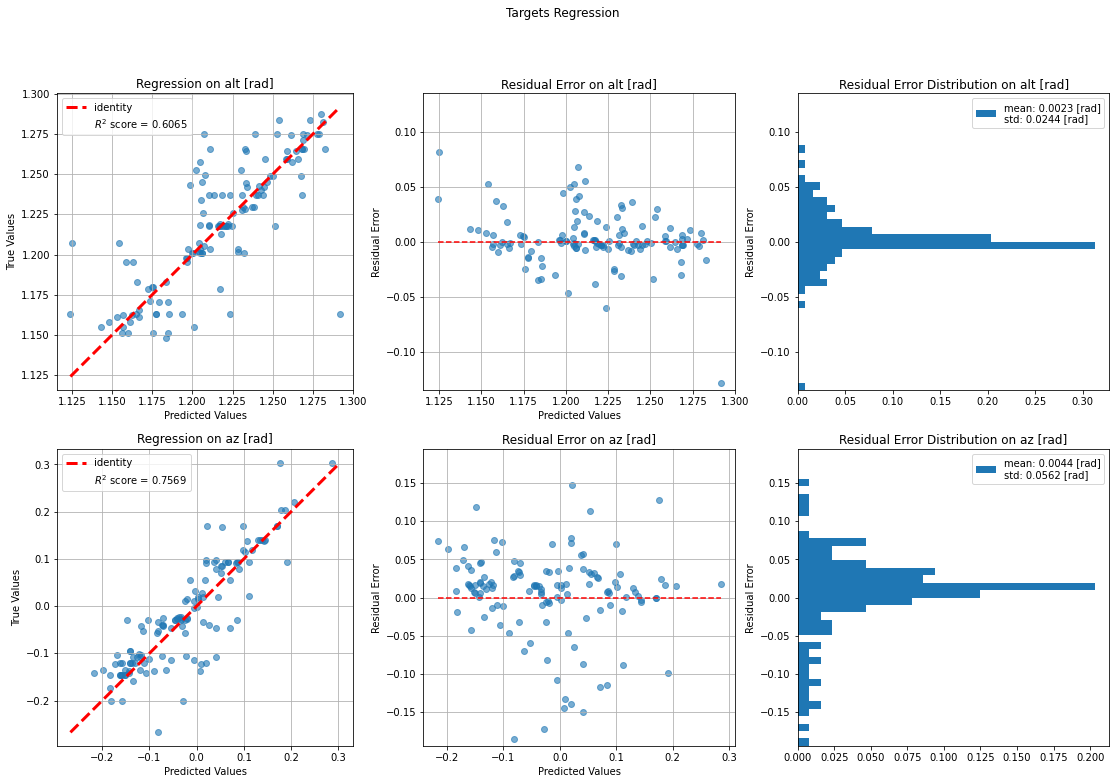

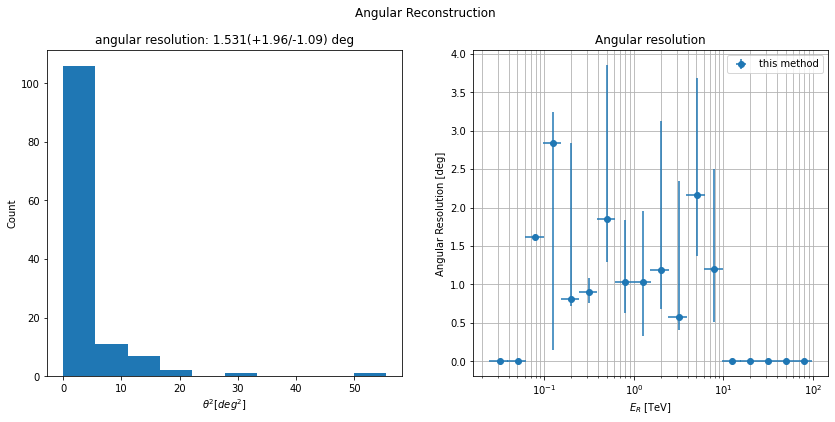

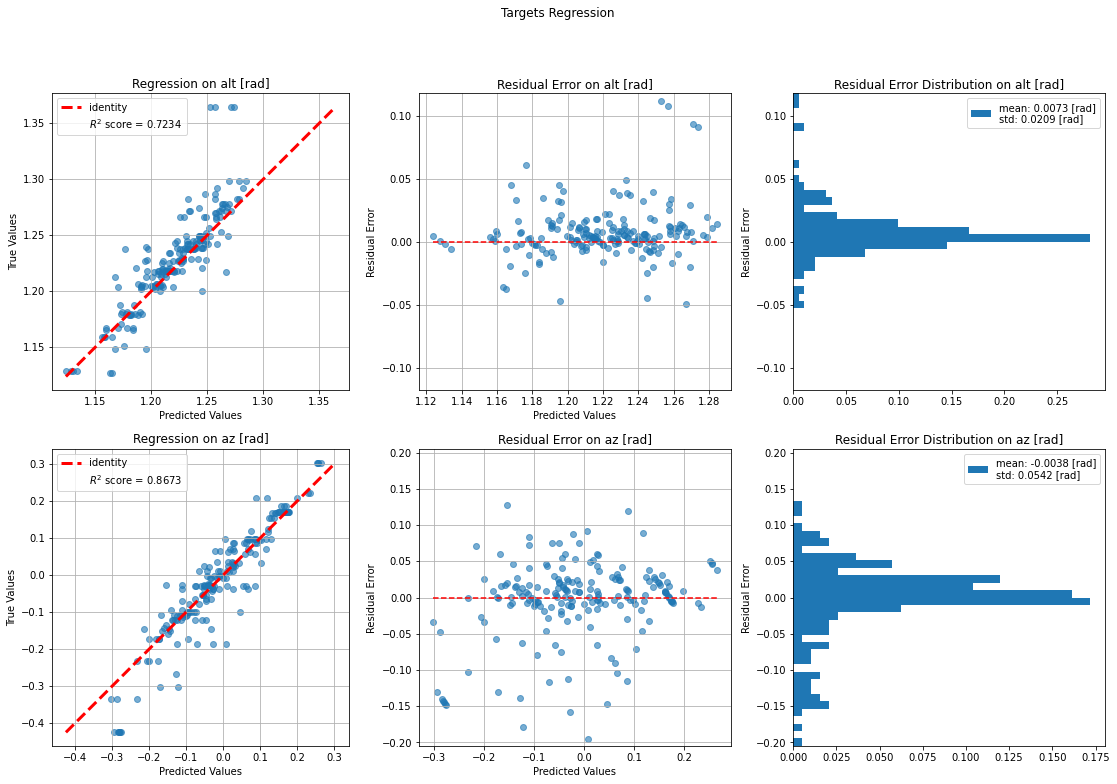

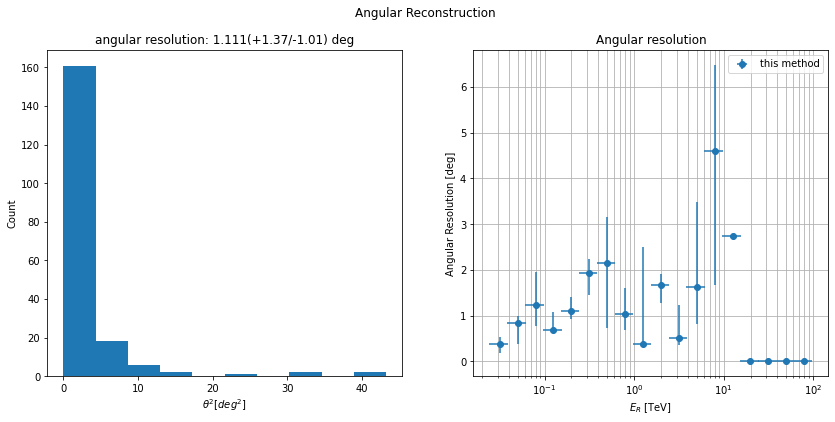

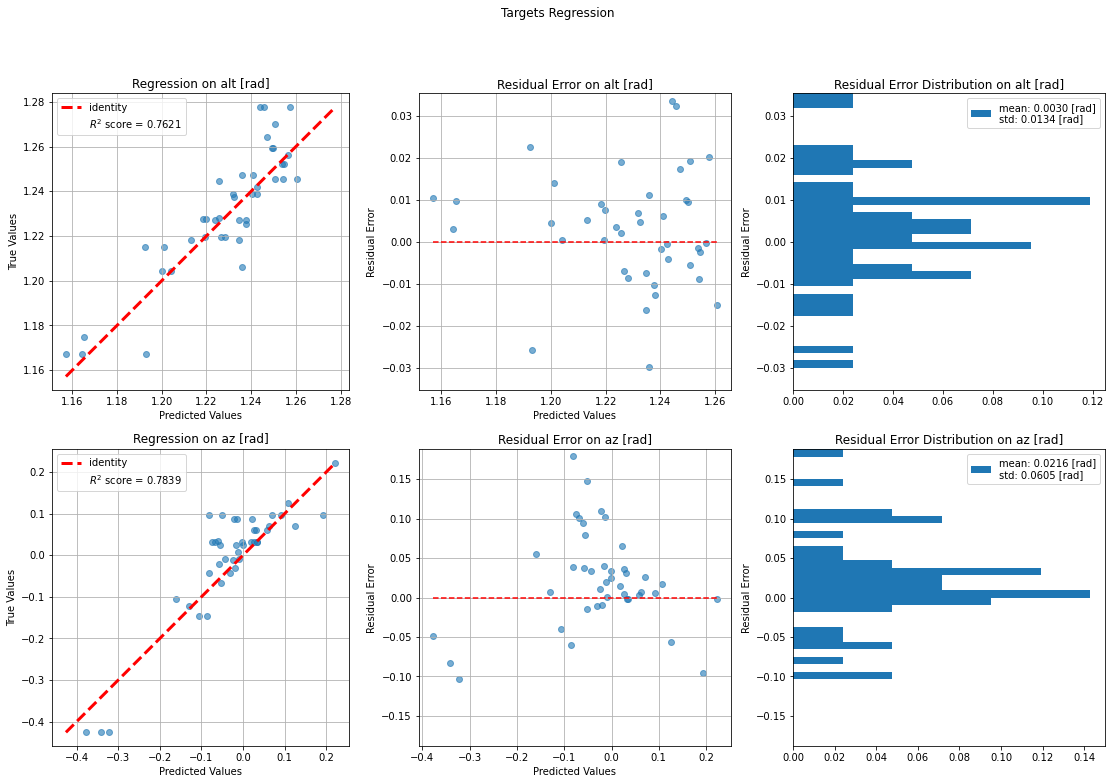

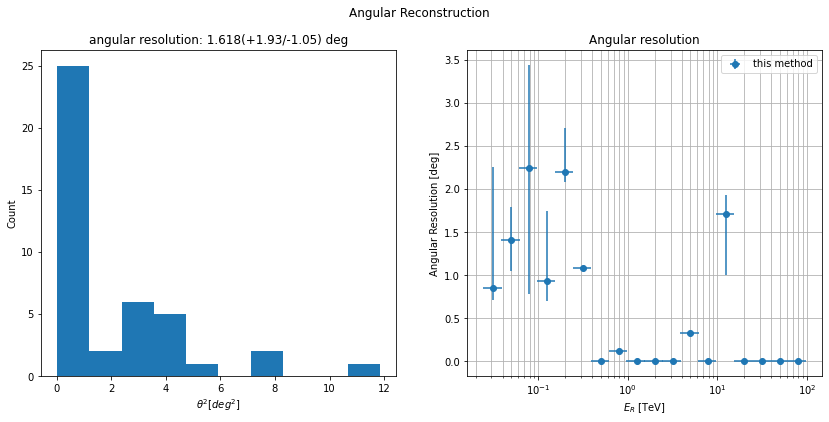

In [82]:
for telescope_i, results in models_results.items():
    if telescope_i == "assembler": continue
    display(HTML(f"<h3>{telescope_i}</h3>"))
    df_ = pd.DataFrame({
        "event_id":         results["event_id"],
        "telescope_id":     results["telescope_id"],
        "telescope_type":   results["telescope_type"],
        "true_alt":         results["targets"][:,0].flatten(),
        "true_az":          results["targets"][:,1].flatten(),
        "pred_alt":         results["predictions"][:,0].flatten(),
        "pred_az":          results["predictions"][:,1].flatten(),
        "true_mc_energy":   results["true_energy"],
    })
    df_ = df_.dropna()
    scores = r2_score(df_[["true_alt", "true_az"]], df_[["pred_alt", "pred_az"]], multioutput="raw_values")
    plot_regression_evaluation(df_, targets, scores)
    plot_error_and_angular_resolution(df_)

## Assembler Predictions


In [68]:
results, predictions = assembler.evaluate(sample_generator, return_event_predictions=display_events, pbar=tqdm)
models_results["assembler"] = results

100%|██████████| 64/64 [00:02<00:00, 22.09it/s]


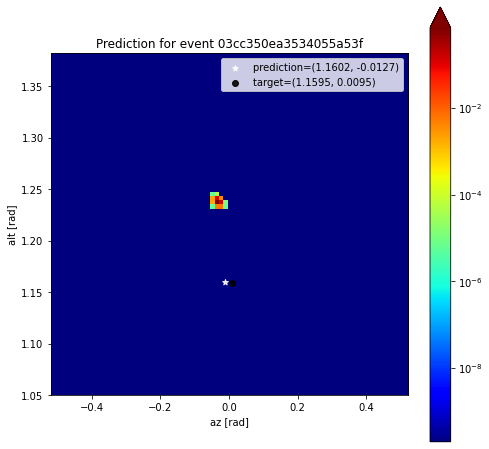

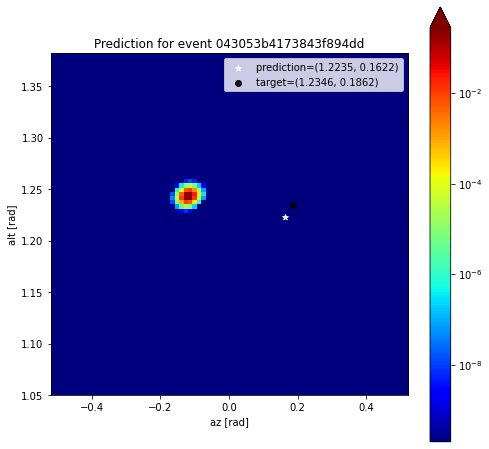

In [85]:
target_domains = assembler.target_domains
target_resolutions = assembler.target_resolutions
targets = assembler.targets

for prediction, prediction_point, target_point, event_id in predictions:
    plot_assembler_prediction(prediction, prediction_point, targets, target_domains, target_resolutions, event_id, target_point)

## Assembler Evaluation

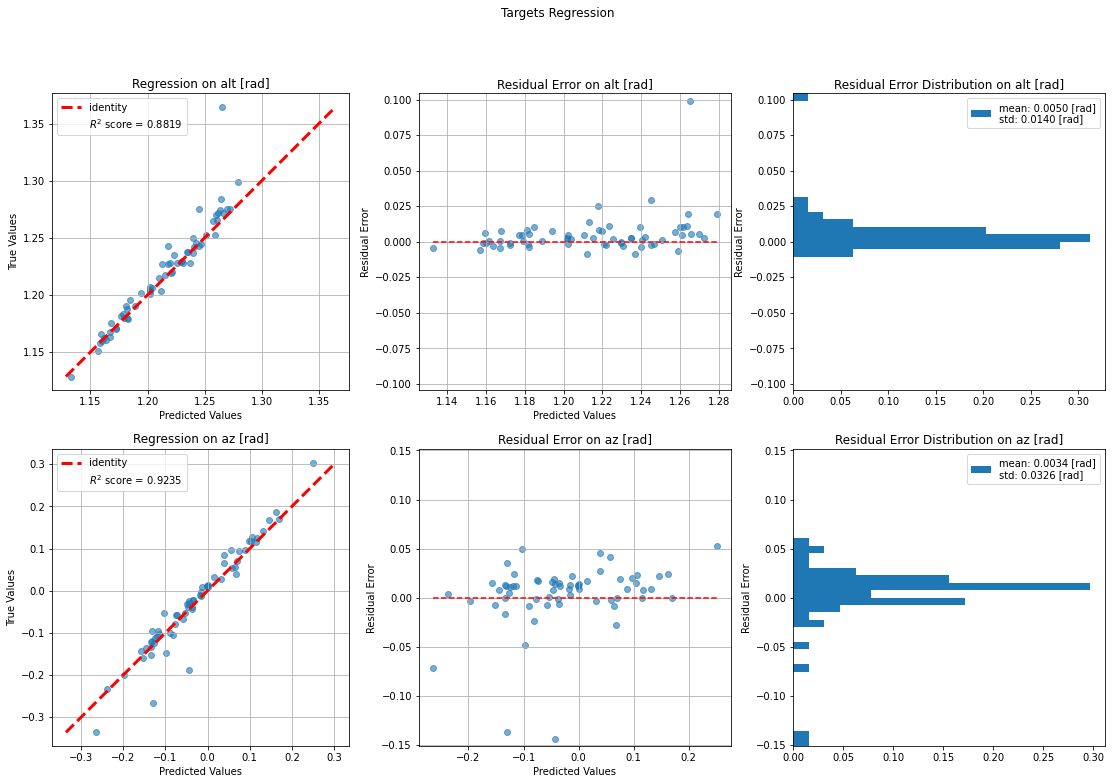

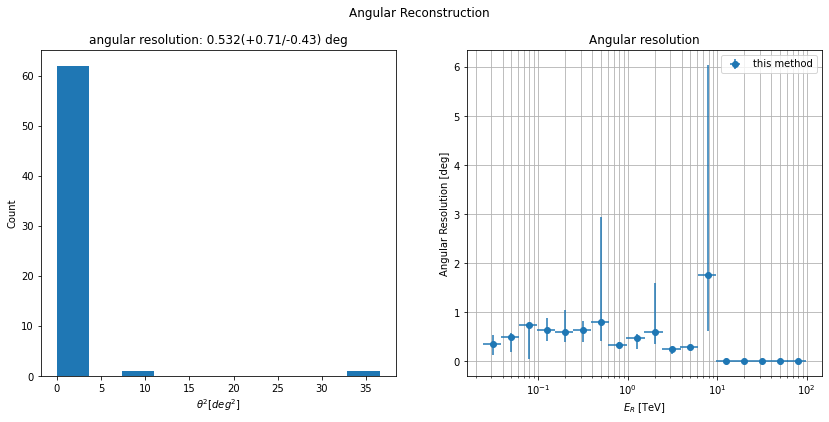

In [89]:
results = models_results["assembler"]
display(HTML(f"<h3>Assembler</h3>"))
df_ = pd.DataFrame({
        "event_id":         results["event_id"],
        "true_alt":         results["targets"][:,0].flatten(),
        "true_az":          results["targets"][:,1].flatten(),
        "pred_alt":         results["predictions"][:,0].flatten(),
        "pred_az":          results["predictions"][:,1].flatten(),
        "true_mc_energy":   results["true_energy"],
})


df_ = df_.dropna()
scores = r2_score(df_[["true_alt", "true_az"]], df_[["pred_alt", "pred_az"]], multioutput="raw_values")
plot_regression_evaluation(df_, targets, scores)
plot_error_and_angular_resolution(df_)

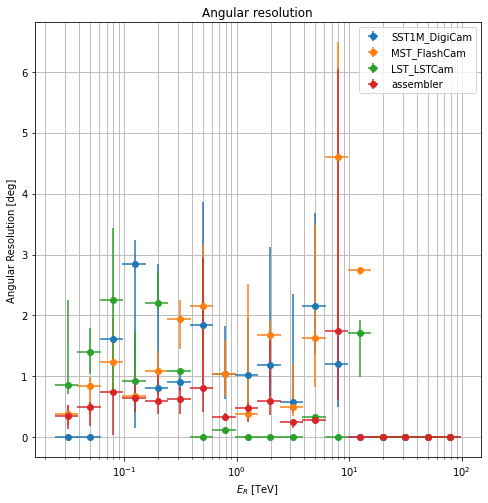

In [95]:
plot_angular_resolution_comparison(models_results)

# Energy Reconstruction


## Load Configuration file

In [103]:
config_file = "/content/drive/My Drive/Projects/gerumo/train/config/colab/energy/umonna_assembler_colab.json"

print(f"Loading config from: {config_file}")
with open(config_file) as cfg_file:
    config = json.load(cfg_file)

# Model
model_name = config["model_name"]
assembler_constructor = ASSEMBLERS[config["assembler_constructor"]]

# Dataset Parameters
output_folder = config["output_folder"]
replace_folder_test = config["replace_folder_test"]
test_events_csv    = config["test_events_csv"]
test_telescope_csv = config["test_telescope_csv"]

# Input and Target Parameters 
telescopes = config["telescopes"]
min_observations = config["min_observations"]
input_image_mode = config["input_image_mode"]
input_image_mask = config["input_image_mask"]
input_features = config["input_features"]
targets = config["targets"]
target_mode = "lineal"
target_shapes = config["target_shapes"]
target_domains = config["target_domains"]
target_resolutions = get_resolution(targets, target_domains, target_shapes)

# Prepare Generator target_mode_config 
target_mode_config = {
    "target_shapes":      tuple([target_shapes[target]      for target in targets]),
    "target_domains":     tuple([target_domains[target]     for target in targets]),
    "target_resolutions": tuple([target_resolutions[target] for target in targets])
}
if target_mode == "probability_map":
    target_sigmas = config["target_sigmas"]
    target_mode_config["target_sigmas"] = tuple([target_sigmas[target] for target in targets])

# Evaluation Parameters
evaluation_config = config["evaluation"]

Loading config from: /content/drive/My Drive/Projects/gerumo/train/config/colab/energy/umonna_assembler_colab.json


In [104]:
pprint.pprint(config, width=1)

{'assembler_constructor': 'umonna',
 'evaluation': {'Assembler': {'save_plots': True,
                              'save_predictions': True,
                              'save_probability': True,
                              'skip': False},
                'LST_LSTCam': {'save_plots': True,
                               'save_predictions': True,
                               'save_probability': True,
                               'skip': False},
                'MST_FlashCam': {'save_plots': True,
                                 'save_predictions': True,
                                 'save_probability': True,
                                 'skip': False},
                'SST1M_DigiCam': {'save_plots': True,
                                  'save_predictions': True,
                                  'save_probability': True,
                                  'skip': False}},
 'input_features': ['x',
                    'y'],
 'input_image_mask': True,
 'input_image_mode': 

## Load Dataset

In [0]:
# Prepare datasets
test_dataset = load_dataset(test_events_csv, test_telescope_csv, replace_folder_test)
test_dataset = aggregate_dataset(test_dataset, az=True, log10_mc_energy=True)
test_dataset = filter_dataset(test_dataset, telescopes, min_observations, target_domains)

# Preprocessing pipes
preprocess_input_pipes = []
preprocess_output_pipes = []

## Data Generator

In [0]:
# Generators
batch_size = 64
telescope_types = [t for t in telescopes.keys() if telescopes[t] is not None]
test_generator = AssemblerGenerator(test_dataset, telescope_types,
                                    batch_size, 
                                    input_image_mode=input_image_mode, 
                                    input_image_mask=input_image_mask, 
                                    input_features=input_features,
                                    targets=targets,
                                    target_mode=target_mode, 
                                    target_mode_config=target_mode_config,
                                    preprocess_input_pipes=preprocess_input_pipes,
                                    preprocess_output_pipes=preprocess_output_pipes,
                                    include_event_id=True,
                                    include_true_energy=True
)

# Small test sample
sample_size = 100 #1000
sample_events = np.random.choice(test_dataset.event_unique_id.unique(), sample_size)
sample_dataset = test_dataset[test_dataset.event_unique_id.isin(sample_events)]

sample_generator = AssemblerGenerator(sample_dataset, telescope_types,
                                    batch_size, 
                                    input_image_mode=input_image_mode, 
                                    input_image_mask=input_image_mask, 
                                    input_features=input_features,
                                    targets=targets,
                                    target_mode="lineal", 
                                    target_mode_config=target_mode_config,
                                    preprocess_input_pipes=preprocess_input_pipes,
                                    preprocess_output_pipes=preprocess_output_pipes,
                                    include_event_id=True,
                                    include_true_energy=True
)

display_events = [i for i,df in sample_dataset.groupby("event_unique_id") if len(df.type.unique()) == 3][:10]

### Generator sample

In [0]:
# Debug: Check if test dataset is loadable
#for i in tqdm(range(len(test_generator))):
#  _ = test_generator[i]

# Debug: Check if sample dataset is loadable
for i in tqdm(range(len(sample_generator))):
    _ = sample_generator[i]

## Load Models

In [107]:
sst = telescopes["SST1M_DigiCam"]
mst = telescopes["MST_FlashCam"]
lst = telescopes["LST_LSTCam"]
pprint.pprint(telescopes, width=1)

{'LST_LSTCam': '/content/drive/Shared '
               'drives/umonna/data/models/energy/small/UMONNA_UNIT_LST_V2_ENERGY_LST_LSTCam_crossentropy_e010_3.1496.h5',
 'MST_FlashCam': '/content/drive/Shared '
                 'drives/umonna/data/models/energy/small/UMONNA_UNIT_MST_V2_ENERGY_MST_FlashCam_crossentropy_e015_3.4590.h5',
 'SST1M_DigiCam': '/content/drive/Shared '
                  'drives/umonna/data/models/energy/small/UMONNA_UNIT_SST_V2_ENERGY_SST1M_DigiCam_crossentropy_e004_3.3022.h5'}


In [0]:
assembler = assembler_constructor(sst1m_model_or_path=sst,
                mst_model_or_path=mst,
                lst_model_or_path=lst,
                targets=targets, target_shapes=target_mode_config["target_shapes"],
                target_domains=target_mode_config["target_domains"],
                target_resolutions=target_mode_config["target_resolutions"],
                assembler_mode="normalized_product",
                point_estimation_mode="expected_value"
)

## Model Unit Predictions


In [0]:
target_domains_ = target_domains if isinstance(target_domains, dict) else target_domains_
targets = assembler.targets
models_results = {}

In [112]:
for telescope_i, model in assembler.models.items():
    display(HTML(f"<h3>{telescope_i}</h3>"))
    # Telescope Sample Dataset
    sample_dataset_telescope = filter_dataset(sample_dataset, [telescope_i], min_observations, target_domains)
    _batch_size =  1 if 0 < len(sample_dataset_telescope) < batch_size else batch_size
    telescope_generator = AssemblerUnitGenerator(sample_dataset_telescope, _batch_size, 
                                            input_image_mode=input_image_mode, 
                                            input_image_mask=input_image_mask, 
                                            input_features=input_features,
                                            targets=targets,
                                            target_mode="lineal",
                                            target_mode_config=target_mode_config,
                                            preprocess_input_pipes=preprocess_input_pipes,
                                            preprocess_output_pipes=preprocess_output_pipes,
                                            include_event_id=True,
                                            include_true_energy=True
                                            )
    # Prepare targets points
    targets_values = []
    event_ids = []
    telescopes_ids = []
    true_energy = []
    predictions = []
    predictions_points = []
    for x, t, meta in tqdm(telescope_generator):
        # Update records
        event_ids.extend(meta["event_id"])
        telescopes_ids.extend(meta["telescope_id"])
        true_energy.extend(meta["true_energy"])
        targets_values.extend(t)
        
        # Predictions
        p = model.predict(x)
        p_points = assembler.point_estimation(p)
        predictions_points.extend(p_points)

        # save some predictions
        for prediction, prediction_point, target, event_id, telescope_id in zip(p, p_points, t, meta["event_id"], meta["telescope_id"]):
            if event_id in display_events:
                #predictions.append((prediction)
                plot_assembler_prediction(prediction, prediction_point, targets, assembler.target_domains, assembler.target_resolutions, (event_id, telescope_id), target)
        
    results = {
        "event_id": np.array(event_ids),
        "telescope_id": np.array(telescopes_ids),
        "telescope_type": np.array([telescope_i]*len(telescopes_ids)),
        "predictions": np.array(predictions_points), 
        "targets": np.array(targets_values), 
        "true_energy": np.array(true_energy),
    }
    models_results[telescope_i] = results

Output hidden; open in https://colab.research.google.com to view.

## Model Unit Evaluation


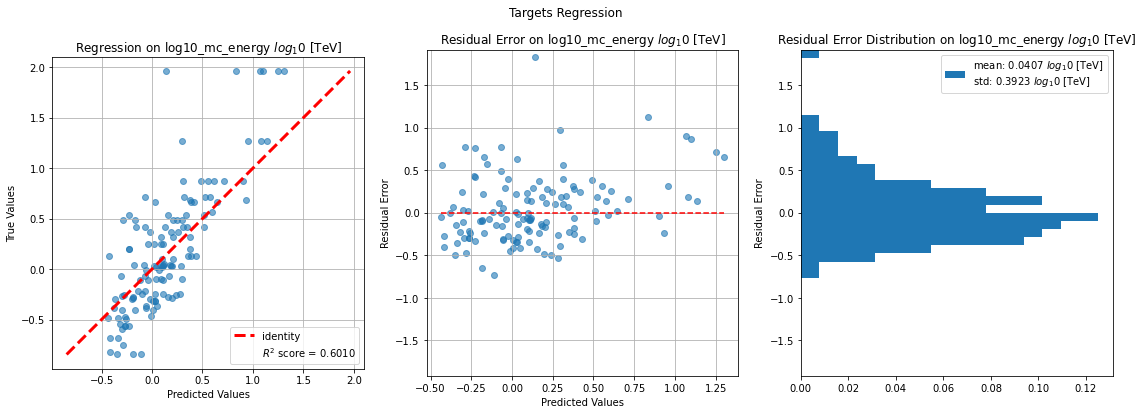

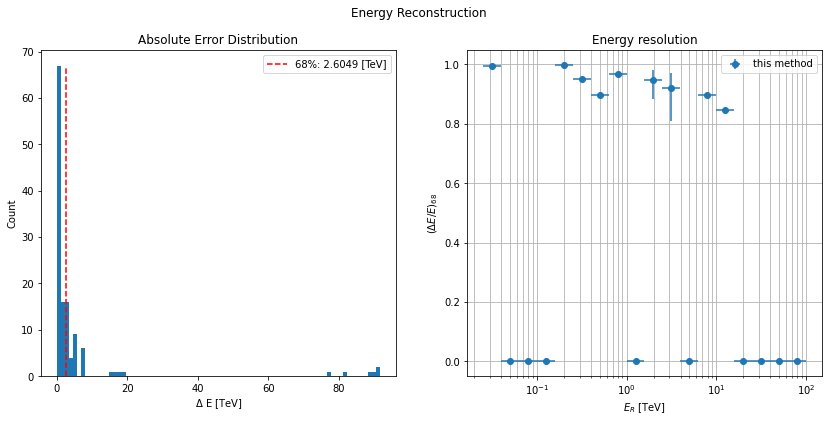

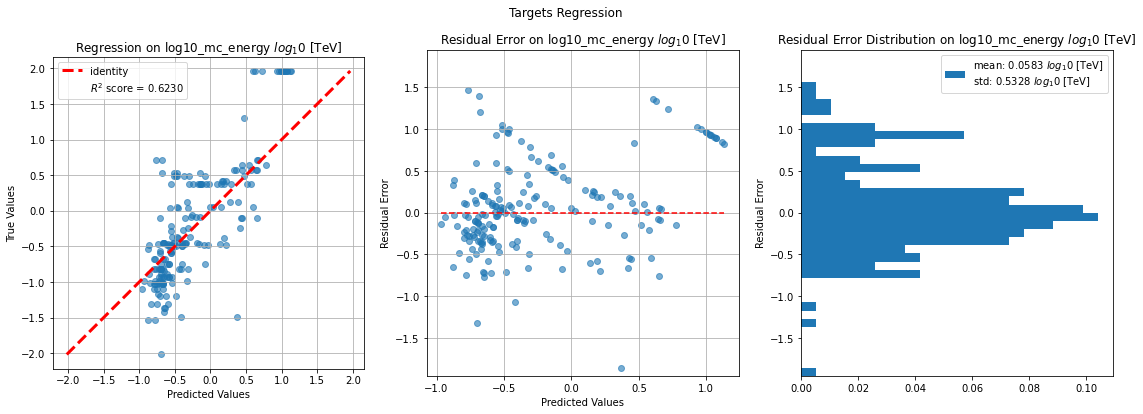

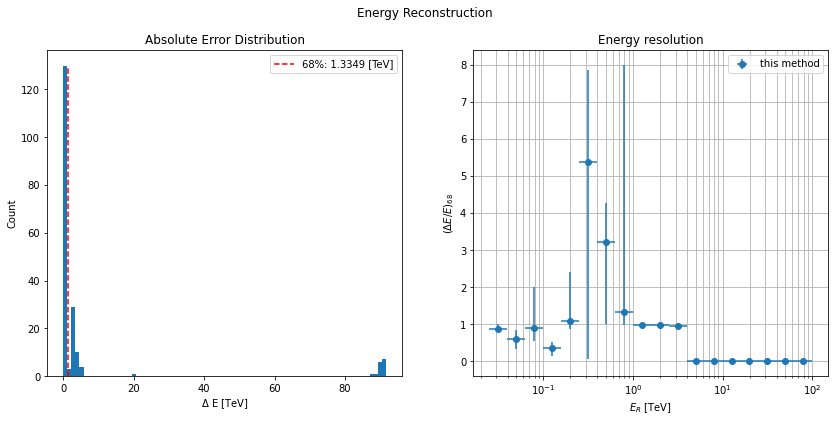

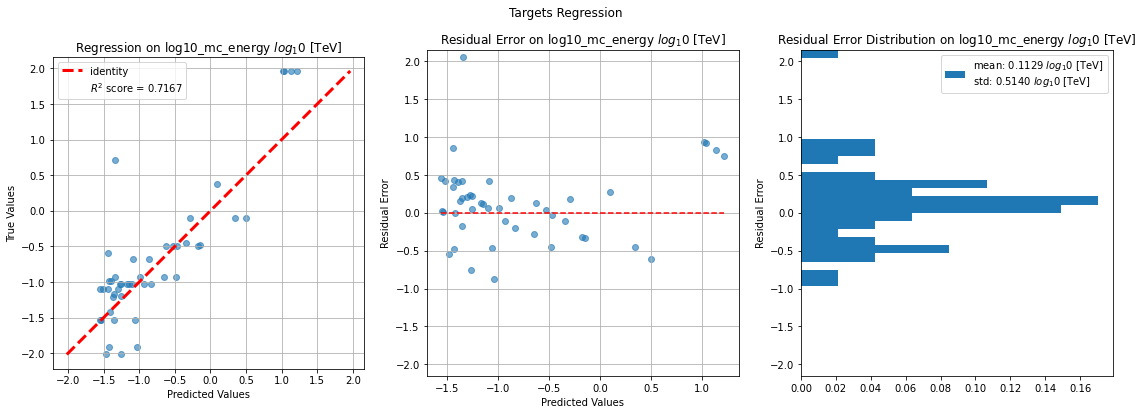

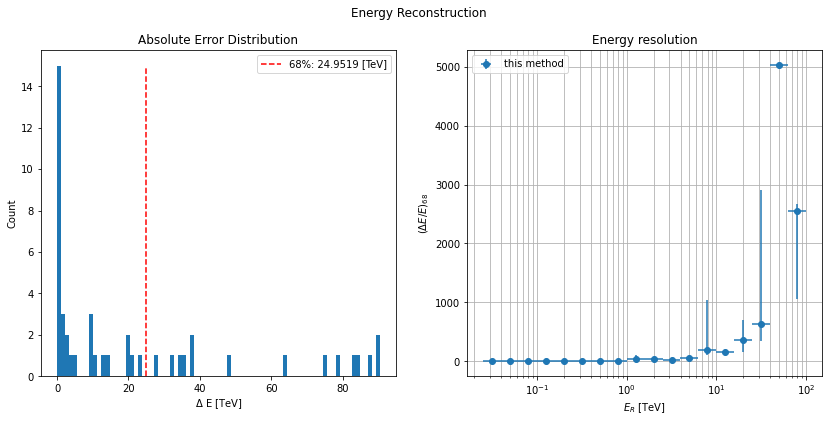

In [113]:
for telescope_i, results in models_results.items():
    if telescope_i == "assembler": continue
    display(HTML(f"<h3>{telescope_i}</h3>"))
    df_ = pd.DataFrame({
        "event_id":             results["event_id"],
        "telescope_id":         results["telescope_id"],
        "telescope_type":       results["telescope_type"],
        "true_log10_mc_energy": results["targets"].flatten(),
        "pred_log10_mc_energy": results["predictions"].flatten(),
        "true_mc_energy":       results["true_energy"],
    })
    df_ = df_.dropna()
    scores = r2_score(df_[["true_log10_mc_energy"]], df_[["pred_log10_mc_energy"]], multioutput="raw_values")
    plot_regression_evaluation(df_, targets, scores)
    plot_error_and_energy_resolution(df_)

## Assembler Predictions


In [0]:
results, predictions = assembler.evaluate(sample_generator, return_event_predictions=display_events, pbar=tqdm)
models_results["assembler"] = results

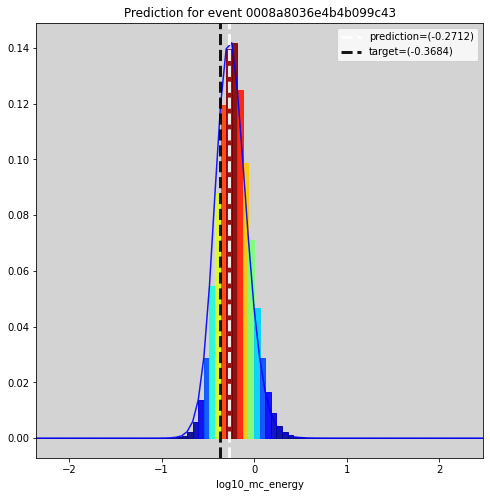

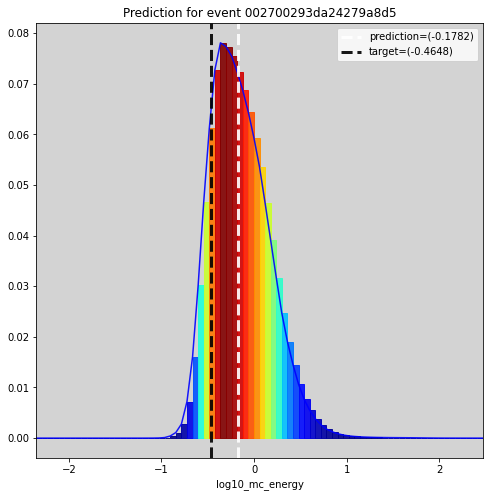

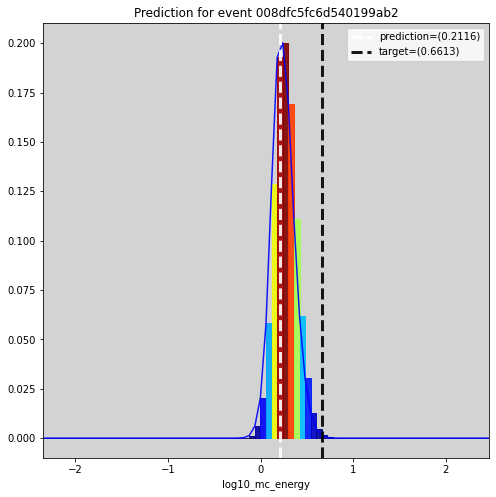

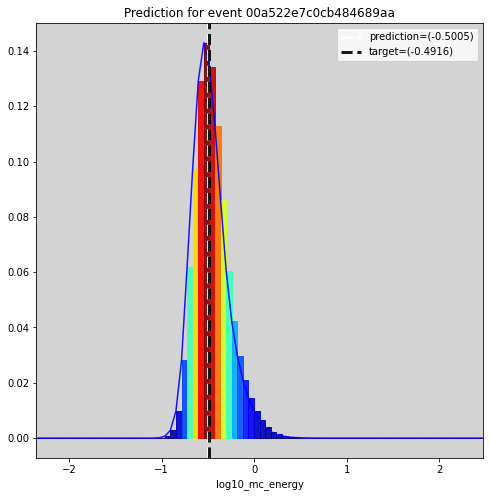

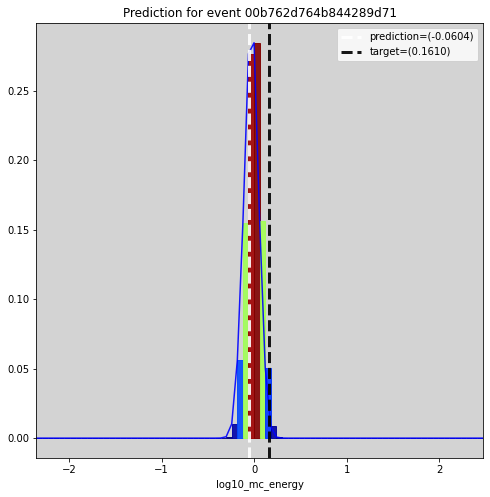

In [0]:
for prediction, prediction_point, target_point, event_id in predictions:
    plot_assembler_prediction(prediction, prediction_point, targets, assembler.target_domains, assembler.target_resolutions, event_id, target_point)

## Assembler Evaluation

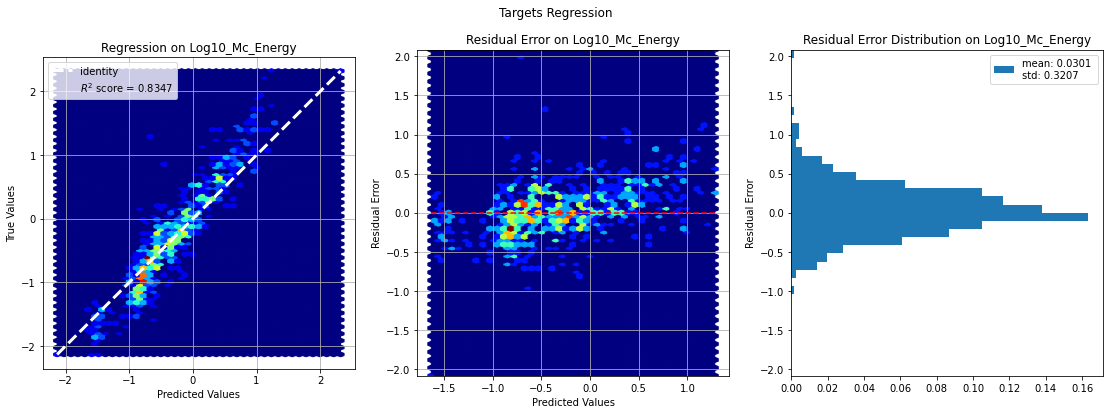

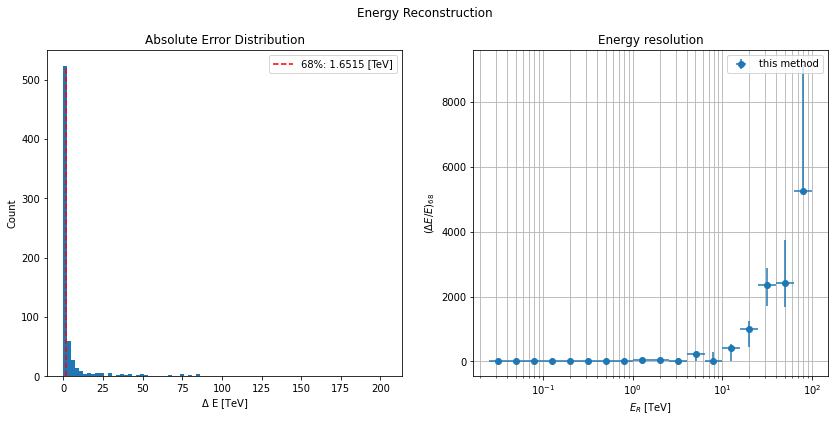

In [0]:
display(HTML(f"<h3>Assembler</h3>"))
df_ = pd.DataFrame({
        "event_id":             results["event_id"],
        "true_log10_mc_energy": results["targets"].flatten(),
        "pred_log10_mc_energy": results["predictions"].flatten(),
        "true_mc_energy":       results["true_energy"],
})


df_ = df_.dropna()
scores = r2_score(df_[["true_log10_mc_energy"]], df_[["pred_log10_mc_energy"]], multioutput="raw_values")
plot_regression_evaluation(df_, targets, scores)
plot_error_and_energy_resolution(df_)

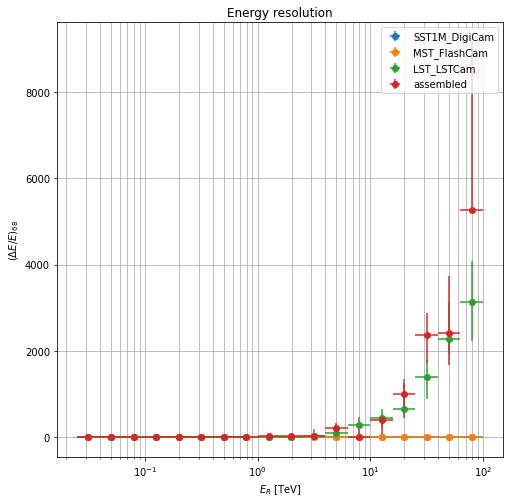

In [0]:
plot_energy_resolution_comparison(models_results)

* calcular incertidumbre
* ajustar una gaussiana y extraer ancho (sigma)
* error relativo